# Model evaluation and recording

In [1]:
import numpy as np
import tensorflow as tf
import gym
from celluloid import Camera
import matplotlib.pyplot as plt
from typing import List, Callable

In [2]:
grayscale_code = ! cat '../implementation/environment/__init__.py'
exec('\n'.join(grayscale_code))

In [6]:
def preprocess(obs):
    obs = tf.gather(tf.constant(grayscale_palette), tf.cast(obs, tf.int32))
    obs = tf.reduce_max(obs, axis=2)
    resized = tf.image.resize(obs, (84, 84))
    return resized.numpy()

In [39]:
def evaluate_model(env_name: str, seed: int, model_path: str, output_type: str,
                   preprocess_func: Callable, recorded: bool = False, max_steps: int = 10000):
    env = gym.make(env_name)
    model = tf.keras.models.load_model(model_path)
    
    env.seed(seed)
    tf.random.set_seed(seed)
    obs = env.reset()
    done = False
    step_count = 0
    reward_sum = 0.
    
    if recorded:
        fig = plt.figure()
        camera = Camera(fig)
    
    while not done and step_count < max_steps:
        
        if recorded:
            image = env.render(mode='rgb_array')
            plt.imshow(image)
            camera.snap()
        
        action_logits = model(tf.expand_dims(preprocess_func(obs), 0))
        
        if output_type == 'categorical':
            action = tf.squeeze(tf.random.categorical(action_logits, 1))
        elif output_type == 'argmax':
            action = tf.math.argmax(action_logits, axis=1)
        else:
            raise Exception('invalid output type')
        
        obs, reward, done, _ = env.step(action.numpy())
        
        reward_sum += reward
        step_count += 1
    
    if recorded:
        animation = camera.animate(interval=40)
        animation.save(f'{env_name}-3.gif')
        
    return reward_sum

MovieWriter ffmpeg unavailable; using Pillow instead.


253.33713397177993

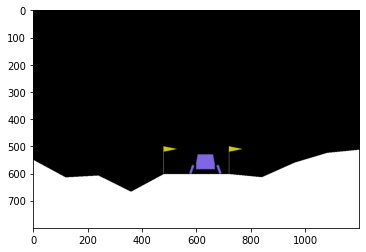

In [11]:
evaluate_model('LunarLander-v2', 56, '/Users/mateusz/Downloads/epoch-32/model',
               output_type='categorical', preprocess_func=lambda x: x, recorded=True)

In [10]:
evaluate_model('LunarLander-v2', 56, '/Users/mateusz/Downloads/epoch-32/model',
               output_type='categorical', preprocess_func=lambda x: x)

253.33713397177993

MovieWriter ffmpeg unavailable; using Pillow instead.


2980.0

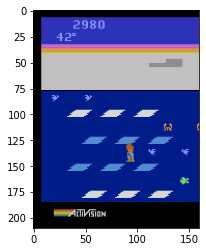

In [35]:
evaluate_model('Frostbite-v0', 40, '/Users/mateusz/Downloads/epoch-42/model', # 6624
               output_type='argmax', preprocess_func=preprocess, recorded=False)

In [36]:
def evaluate_model_with_seeds(env_name: str, seeds: List[int], model_path: str, output_type: str,
                              preprocess_func: Callable, max_steps: int = 10000):
    envs = []
    obses = []
    dones = np.full(len(seeds), False)
    count = 0
    rewards = np.zeros(len(seeds))
    model = tf.keras.models.load_model(model_path)
    tf.random.set_seed(seeds[0])
    
    for seed in seeds:
        env = gym.make(env_name)
        env.seed(seed)
        obs = env.reset()
        envs.append(env)
        obses.append(obs)

    while not np.all(dones) and count < max_steps:
        indices = np.where(~dones)[0]
        prepr = np.array([preprocess_func(obses[i]) for i in indices])
        action_logits = model(prepr)
        if output_type == 'categorical':
            actions = tf.squeeze(tf.random.categorical(action_logits, 1), axis=1)
        elif output_type == 'argmax':
            actions = tf.math.argmax(action_logits, axis=1)
        else:
            raise Exception('invalid output type')
        for idx, action in zip(indices, actions):
            obs, reward, done, _ = envs[idx].step(action.numpy())
            obses[idx] = obs
            dones[idx] = done
            rewards[idx] += reward
        count += 1

    return list(zip(seeds, rewards))

In [9]:
evaluate_model_with_seeds('LunarLander-v2', [123, 44, 56], '/Users/mateusz/Downloads/epoch-32/model',
               output_type='categorical', preprocess_func=lambda x: x)

[(123, 19.46622321246251), (44, 218.57011511168776), (56, 252.32070182359917)]

In [38]:
evaluate_model_with_seeds('Frostbite-v0', [7,8,9,10,11], '/Users/mateusz/Downloads/epoch-40/model',
               output_type='argmax', preprocess_func=preprocess)

[(7, 3170.0), (8, 1240.0), (9, 2980.0), (10, 1200.0), (11, 2410.0)]

MovieWriter ffmpeg unavailable; using Pillow instead.


3170.0

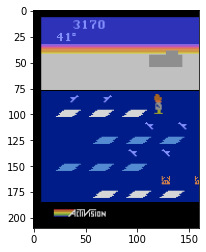

In [40]:
evaluate_model('Frostbite-v0', 7, '/Users/mateusz/Downloads/epoch-40/model',
               output_type='argmax', preprocess_func=preprocess, recorded=True)